# 사전 준비

In [ ]:
!pip install transformers

# 데이터 불러오기

In [2]:
import pandas as pd

interview_data = pd.read_csv("/content/drive/Othercomputers/내 컴퓨터/Interview_Writer/Interview_Data.csv")

In [ ]:
interview_data.head(3)

,Question,Answer
0,특별히 회사를 선택한 이유와 입사 후 포부에 대해 기술해주십시오.,"대학교 1학년 2학기, 컴퓨터 프로그래밍 및 실습수업을 통해 프로그래밍에 관심을 가..."
1,지원직무를 선택한 이유와 해당직무에 본인이 적임자라고 생각하는 이유를 기술해주십시오.,"대학교 2학년 1학기, 프로그래밍언어 수업을 통해 영상처리를 처음 접하게 되었습니다..."
2,본인이 다니고 싶은 회사와 동료들은 어떤 모습인지 기술해주십시오.,제가 다니고 싶은 회사는 개인 역량을 강화하는데 도움을 주는 회사입니다. 회사에 취...


In [ ]:
interview_data.tail(3)

,Question,Answer
117,"개발을 하면서 겪었던 기술적인 문제를 서술하고, 그 과정에서 겪었던 시행착오와 그에...",프로그래머는 `조금 더 편리한 방법은 없을까?` 궁금하지 않다면 더 이상의 발전은 ...
118,입사 후 이루고 싶은 최종목표는 무엇입니까?,"입사 후, 기존에 있던 업무 매뉴얼과 문서들을 바탕으로 업무에 빠르게 적응하겠습니다..."
119,성격의 장점과 단점을 기술해 주시기 바랍니다. 입사 후 장점은 어떻게 활용하고 단점...,함께 완성한 것이 혼자 완성한 것보다 결과 그 이상의 가치를 가집니다. 혼자 완성하...


# 텍스트 전처리

In [ ]:
!pip install soynlp

In [4]:
# 회사이름 리스트를 정규표현식으로 변경
file_path = '/content/drive/Othercomputers/내 컴퓨터/Interview_Writer/companies_name.txt'

with open(file_path) as f:
    names_list = f.read().splitlines()

for i in range(0, len(names_list)):
    if i == 0:
        names_list[i] = str('(' + names_list[i])
    elif i == (len(names_list)-1):
        names_list[i] = str('|' + names_list[i] + ')')
    else:
        names_list[i] = str('|' + names_list[i])

names_str = ''.join(names_list)

print(names_str)

(\x28주\x29동부|AKIS|CJ올리브네트웍스|DB아이앤씨|GS ITM|IBK시스템|KB데이터시스템|KT|KT DS|LG CNS|LG 유플러스|LS아이티씨|NDS|NH농협은행|SK|SK C&C|교보정보통신|농협정보시스템|동국시스템즈|동양네트웍스|동양시스템즈|두산디지털이노베이션|롯데백화점|롯데정보통신|메가존클라우드|메타넷대우정보|미라콤아이앤씨|베스핀글로벌|뷰웍스|비즈테크파트너스|삼성SDS|삼성전자|섹타나인|신세계아이앤씨|신한|신한데이타시스템|신한DS|신한금융그룹|신한카드|쌍용정보통신|쓱|아시아나IDT|우리에프아이에스|우리은행|유호스트|줌인터넷|카카오엔터프라이즈|케이뱅크|코오롱베니트|태광|티몬|티맥스소프트|티시스|포스코ICT|하나금융티아이|한국데이터베이스진흥원|한진정보통신|한화시스템/ICT|현대HDS|현대IT&E|현대모비스|현대아이파크몰|현대오토에버|현대오토에버|휴머스온)


In [5]:
import re
from soynlp.normalizer import repeat_normalize

pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣]+')
whitespace_symbol = re.compile(r'[\t\r\n\f\v]+')

In [6]:
def text_preprocess(x):
    x = pattern.sub(' ', x)                     # 일반적으로 사용하는 특수문자, 영어, 한글제외 공백으로 치환
    x = whitespace_symbol.sub(' ', x)           # space(공백문자)를 제외한 whitespace 문자를 공백으로 치환
    x = re.sub(names_str, 'XX', x)
    x = x.strip()                               # 문자의 시작과 끝에서 공백제거
    x = repeat_normalize(x, num_repeats=2)      # 반목되는 문자의 축약 횟수 2개로 줄임
    return x

In [ ]:
interview_data['Answer'][16]

"OOOOOO에서 주관하는 '제O기 사회리더 대학생 멘토링' 활동 때 팀워크를 발휘하여 공동의 목표 달성에 이바지한 경험이 있습니다. 저희는 고객과 헤어샵 사이 중개 플랫폼을 만들어보자는 목표를 설정하였습니다. 프로젝트에 고객수요조사, 플랫폼 설계 등 혼자 하기에는 무리가 있어서 팀을 구성하였고 저를 포함 5명이 팀을 이루게 되었습니다.\n\n저는 처음 본 조원들에게 효율적인 업무 분담하는 과정이 큰 난관이었습니다. 조원들 간의 장점을 최대한 끌어낼 방법을 찾기 위해 노력했습니다. 장시간 소통을 통해 문제를 해결하는 것이 우선이었습니다. 작품 회의를 하며 여러 업무를 분배하는 과정에서 개인마다 각자 잘할 수 있는 일이 있다는 사실을 인지할 수 있었습니다. 이를 바탕으로, 디자인 경력이 있는 조원에게는 디자인 업무, 평소에 책 읽기를 좋아하고 글 쓰는 재주가 있는 조원에게는 계획서 작성, 플랫폼 구현경험이 있는 조원에게는 App 구성 등 효율적인 업무분담을 할 수 있었습니다.\n\n1년이라는 장기프로젝트를 진행하면서 가장 힘들었던 점은 시간과 공간의 제약이었습니다. 각자의 전공공부와 프로젝트를 병행하는 시간적인 제약과 각각 다른 학교 출신으로 공간적인 제약을 조율하는 것은 정말 힘든 일이었습니다. 프로젝트를 자율적으로 진행하다 보니 진행 상황이 더뎌지는 상황을 확인할 수 있었습니다. 저희는 주 1회 정기적으로 모여 개개인의 업무 상황을 보고하고 서로의 업무진행에 대해 피드백하기로 했습니다. 피드백을 통해 구체적인 메시지를 전달하여 서로가 학습하고 성장할 수 있게 만들었습니다.\n\n팀워크의 가치를 현대모비스에서 실행해보고 싶습니다. 협동 부서의 역할을 이해하고 소통하여 팀원 간, 부서 간의 징검다리가 되겠습니다."

In [7]:
interview_data.Question = interview_data.Question.apply(text_preprocess)
interview_data.Answer = interview_data.Answer.apply(text_preprocess)

In [ ]:
interview_data['Answer'][16]

"OO에서 주관하는 '제O기 사회리더 대학생 멘토링' 활동 때 팀워크를 발휘하여 공동의 목표 달성에 이바지한 경험이 있습니다. 저희는 고객과 헤어샵 사이 중개 플랫폼을 만들어보자는 목표를 설정하였습니다. 프로젝트에 고객수요조사, 플랫폼 설계 등 혼자 하기에는 무리가 있어서 팀을 구성하였고 저를 포함 5명이 팀을 이루게 되었습니다. 저는 처음 본 조원들에게 효율적인 업무 분담하는 과정이 큰 난관이었습니다. 조원들 간의 장점을 최대한 끌어낼 방법을 찾기 위해 노력했습니다. 장시간 소통을 통해 문제를 해결하는 것이 우선이었습니다. 작품 회의를 하며 여러 업무를 분배하는 과정에서 개인마다 각자 잘할 수 있는 일이 있다는 사실을 인지할 수 있었습니다. 이를 바탕으로, 디자인 경력이 있는 조원에게는 디자인 업무, 평소에 책 읽기를 좋아하고 글 쓰는 재주가 있는 조원에게는 계획서 작성, 플랫폼 구현경험이 있는 조원에게는 App 구성 등 효율적인 업무분담을 할 수 있었습니다. 1년이라는 장기프로젝트를 진행하면서 가장 힘들었던 점은 시간과 공간의 제약이었습니다. 각자의 전공공부와 프로젝트를 병행하는 시간적인 제약과 각각 다른 학교 출신으로 공간적인 제약을 조율하는 것은 정말 힘든 일이었습니다. 프로젝트를 자율적으로 진행하다 보니 진행 상황이 더뎌지는 상황을 확인할 수 있었습니다. 저희는 주 1회 정기적으로 모여 개개인의 업무 상황을 보고하고 서로의 업무진행에 대해 피드백하기로 했습니다. 피드백을 통해 구체적인 메시지를 전달하여 서로가 학습하고 성장할 수 있게 만들었습니다. 팀워크의 가치를 XX에서 실행해보고 싶습니다. 협동 부서의 역할을 이해하고 소통하여 팀원 간, 부서 간의 징검다리가 되겠습니다."

# 데이터 구축

HuggingFace's BPEtokenizer

In [8]:
tokenize_data = interview_data.values.tolist()

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

tokenizer = Tokenizer(BPE(unk_token="<unk>"))
trainer = BpeTrainer(
                vocab_size = 2000,          # vocab_size의 최댓값은 4375
                limit_alphabet = 10000,
                min_frequency = 3,
                special_tokens = ["<unk>", "<s>", "</s>", "<pad>", "<mask>"],
                continuing_subword_prefix = "▁"
                )

tokenizer.pre_tokenizer = Whitespace()

tokenizer.train_from_iterator(tokenize_data, trainer)

In [11]:
tokenizer.save('/content/drive/Othercomputers/내 컴퓨터/Interview_Writer/BPE_tokenizer.json')

**데이터셋 구축**

In [8]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file='/content/drive/Othercomputers/내 컴퓨터/Interview_Writer/BPE_tokenizer.json')

In [9]:
import numpy as np
from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, docs, tokenizer, max_len):
        super().__init__()
        self.docs = docs
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.bos_id = tokenizer.convert_tokens_to_ids("<s>")
        self.eos_id = tokenizer.convert_tokens_to_ids("</s>")
        self.pad_id = tokenizer.convert_tokens_to_ids("<pad>")

    # padding 및 데이터 size 일치화 함수 (input_ids)
    def add_padding(self, inputs):
        if len(inputs) < self.max_len:
            pad = np.array([self.pad_id]*(self.max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
        else:
            inputs = inputs[:self.max_len]
        return inputs

    def __len__(self):  
        return len(self.docs)

    def __getitem__(self, idx):
        Q = self.docs.Question[idx]
        A = self.docs.Answer[idx]

        Q_token = [self.bos_id] + self.tokenizer.encode(Q) + [self.eos_id]
        A_token = self.tokenizer.encode(A) + [self.eos_id]
        
        # <s> Q </s> A </s> <pad>...
        input_ids = Q_token + A_token
        input_ids = self.add_padding(input_ids)

        # attention_mask(어텐션마스크) = Q+A 길이 1 + 나머지(패딩) 0
        # token_type_ids(세그먼트 정보) = Q 0 + A 1 + 나머지 0
        if (self.max_len - len(Q_token+A_token)) > 0:
            attention_mask = [1]*(len(Q_token+A_token)) + [0]*(self.max_len - len(Q_token+A_token))
            token_type_ids = [0]*len(Q_token) + [1]*len(A_token) + [0]*(self.max_len - len(Q_token+A_token))
        else:
            attention_mask = [1]*(self.max_len)
            token_type = [0]*len(Q_token) + [1]*(self.max_len - len(A_token))

        # A </s> <pad>...
        labels = self.tokenizer.encode(A) + [self.eos_id]
        labels = self.add_padding(labels)

        return {'input_ids': np.array(input_ids, dtype=np.int_),
                'attention_mask': np.array(attention_mask, dtype=np.int_),
                'token_type_ids': np.array(token_type_ids, dtype=np.int_),
                'labels': np.array(labels, dtype=np.int_)}

In [ ]:
Q_total = 0
A_total = 0

for i in range(0, len(interview_data)):

    question_length = len(interview_data.Question[i])
    answer_length = len(interview_data.Answer[i])

    Q_total += question_length
    A_total += answer_length

print("질문 평균길이 : ", (Q_total/len(interview_data)))
print("답 평균길이 : ", (A_total/len(interview_data)))

질문 평균길이 :  49.475
답 평균길이 :  651.2166666666667


In [10]:
train_set = DataSet(interview_data, tokenizer=fast_tokenizer, max_len=1024)

In [16]:
train_set[0]

{'input_ids': array([   1,  801, 1025, ...,    3,    3,    3]),
 'attention_mask': array([1, 1, 1, ..., 0, 0, 0]),
 'token_type_ids': array([0, 0, 0, ..., 0, 0, 0]),
 'labels': array([1796, 1187,   18, ...,    3,    3,    3])}

**데이터로더 구축**

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_set, shuffle=False, batch_size=1)

In [17]:
next(iter(train_dataloader))

{'input_ids': tensor([[   1,  801, 1025,  ...,    3,    3,    3]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0]]),
 'labels': tensor([[1796, 1187,   18,  ...,    3,    3,    3]])}

# 모델 정의 

In [12]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss

from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions
from typing import Optional, Union, Tuple

**GPT에서 사용되는 Conv1D**

In [13]:
# weight가 transpose된 Linear layer

class Conv1D(nn.Module):
    def __init__(self, nf, nx):     # nf : output / nx : input
        super().__init__()
        self.nf = nf
        self.weight = nn.Parameter(torch.empty(nx, nf))
        self.bias = nn.Parameter(torch.zeros(nf))
        nn.init.normal_(self.weight, std=0.02)

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)     # Matrix multiplication
        x = x.view(size_out)
        return x

**Decoder**

In [14]:
class Decoder_Block(nn.Module):
    def __init__(self, hidden_size, max_position_embeddings, layer_idx=None):
        super().__init__()

        hidden_size = hidden_size

        # Layer Normalization before attention
        self.ln_1 = nn.LayerNorm(hidden_size, eps=1e-5)

        # Attention
        max_positions = max_position_embeddings
        
        self.register_buffer(
            "bias",
            torch.tril(torch.ones((max_positions, max_positions), dtype=torch.bool)).view(
                1, 1, max_positions, max_positions
            ),
        )
        self.embed_dim = hidden_size        
        self.num_heads = 8                 # attention heads
        self.head_dim = self.embed_dim // self.num_heads    # attention head size
        self.split_size = self.embed_dim
        self.layer_idx = layer_idx

        self.c_attn = Conv1D(3 * self.embed_dim, self.embed_dim)
        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(p = 0.1)
        self.resid_dropout = nn.Dropout(p = 0.1)

        # Layer Normalization after attention
        self.ln_2 = nn.LayerNorm(hidden_size, eps=1e-5)

        # MLP
        intermediate_size = 4 * hidden_size
        
        self.MLP_c_fc = Conv1D(intermediate_size, self.embed_dim)
        self.MLP_c_proj = Conv1D(self.embed_dim, intermediate_size)
        self.act = nn.GELU()
        self.MLP_drop = nn.Dropout(p = 0.1)

    def _attn(self, query, key, value, attention_mask=None, head_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))       # query와 key의 전치행렬의 곱
        attn_weights = attn_weights / torch.full(
            [], value.size(-1) ** 0.5, dtype=attn_weights.dtype, device=attn_weights.device
        )

        # Cross-Attention을 사용하지 않아 일반적인 Attention으로 casual_mask를 구현
        query_length, key_length = query.size(-2), key.size(-2)     # query와 key의 마지막 두번째 차원의 크기(seq_length)
        causal_mask = self.bias[:, :, key_length - query_length : key_length, :key_length]  # (batch_size, num_heads, query_length, key_length)
            
        mask_value = torch.finfo(attn_weights.dtype).min        # attn_weights의 데이터 타입에 맞는 최소값으로 설정
        mask_value = torch.tensor(mask_value, dtype=attn_weights.dtype).to(attn_weights.device)     # mask_value를 생성하고, attn_weights와 동일한 디바이스에 있는 데이터 타입으로 변환

        attn_weights = torch.where(causal_mask, attn_weights, mask_value)   # attn_weights에서 쿼리 토큰에 대한 이전 토큰의 어텐션만을 유지하고, 나머지 위치에는 마스킹 값을 적용

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)      # Softmax
        attn_weights = attn_weights.type(value.dtype)                   # Value와 같은 타입으로 Downcast
        attn_weights = self.attn_dropout(attn_weights)                  # Dropout

        attn_output = torch.matmul(attn_weights, value)                 # attn_weights와 value의 곱
        return attn_output, attn_weights
        
    # hidden_size를 attn_head_size와 num_head로 나누는 함수
    def _split_heads(self, tensor, num_heads, attn_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    # attn_head_size와 num_head를 hidden_size로 병합하는 함수
    def _merge_heads(self, tensor, num_heads, attn_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(
            self,
            hidden_states: Optional[Tuple[torch.FloatTensor]],
            attention_mask: Optional[torch.FloatTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None
        ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:

        """Layer Normalization before attention"""
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)

        """Attention"""
        query, key, value = self.c_attn(hidden_states).split(self.split_size, dim=2)    # Conv1D + split

        query = self._split_heads(query, self.num_heads, self.head_dim)     # split_head
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        attn_output, attn_weights = self._attn(query, key, value, attention_mask, head_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)     # merge
        attn_output = self.c_proj(attn_output)          # Conv1D
        attn_output = self.resid_dropout(attn_output)   # Dropout
        present=None

        attn_outputs = (attn_output, present)

        """Layer Normalization after attention + Adding Tensor"""
        attn_output = attn_outputs[0]       # output_attn: a, present, (attentions)
        hidden_states = attn_output + residual      # residual connection

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)

        """MLP"""
        hidden_states = self.MLP_c_fc(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.MLP_c_proj(hidden_states)
        hidden_states = self.MLP_drop(hidden_states)

        """Adding Tensor"""
        hidden_states = hidden_states + residual    # residual connection
        outputs = (hidden_states,) + attn_outputs[1:]

        return outputs      # hidden_states, present, (attentions, cross_attentions)

**전체 모델 구성**

In [15]:
class Decoder_Model(nn.Module):
    def __init__(self, vocab_size, hidden_size=64, max_position_embeddings=1024):
        super().__init__()

        hidden_size = hidden_size
        self.embed_dim = hidden_size

        self.wte = nn.Embedding(vocab_size, self.embed_dim)     # vocab_size * hidden_size
        self.wpe = nn.Embedding(max_position_embeddings, self.embed_dim)    # max_position_embeddings * hidden_size

        self.drop = nn.Dropout(p = 0.1)
        self.h = nn.ModuleList([Decoder_Block(hidden_size, max_position_embeddings, layer_idx=i) for i in range(4)])    # Attention+MLP를 4층
        self.ln_f = nn.LayerNorm(self.embed_dim, eps=1e-5)
        self.lm_head = nn.Linear(self.embed_dim, vocab_size, bias=False)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
        ) -> Union[Tuple, CausalLMOutputWithCrossAttentions]:
        
        """Embedding Layer"""
        # Word Embedding 입력 = input_ids
        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])
        batch_size = input_ids.shape[0]
        device = input_ids.device

        # Token Type Embedding 입력 = token_type_ids
        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, input_shape[-1])

        # Position Embedding 입력 = position_ids (create)
        past_length = 0     # past_key_values is None
        past_key_values = tuple([None] * len(self.h))
        position_ids = torch.arange(past_length, input_shape[-1] + past_length, dtype=torch.long, device=device)
        position_ids = position_ids.unsqueeze(0).view(-1, input_shape[-1])

        # 2D attention으로 3D attention을 만듦([batch_size, num_heads, from_seq_length, to_seq_length])
        if attention_mask is not None:
            attention_mask = attention_mask.view(batch_size, -1)
            attention_mask = attention_mask[:, None, None, :]
            attention_mask = attention_mask.to(dtype=torch.float16)    # fp16 compatibility (GPU 16비트 부종소수점 호환성)
            attention_mask = (1.0 - attention_mask) * torch.finfo(torch.float16).min
        
        # Word Embedding
        inputs_embeds = self.wte(input_ids)
        
        # Position Embedding
        position_embeds = self.wpe(position_ids)
        hidden_states = inputs_embeds + position_embeds
        
        # Token Type Embedding
        if token_type_ids is not None:
            token_type_embeds = self.wte(token_type_ids)
            hidden_states = hidden_states + token_type_embeds

        # Dropout
        hidden_states = self.drop(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)

        """ModuleList (attention, multi-layer perceptron)"""
        for i, (block, layer_past) in enumerate(zip(self.h, past_key_values)): 
            outputs = block(
                hidden_states,
                attention_mask=attention_mask
            )
            hidden_states = outputs[0]

        """LayerNorm"""
        hidden_states = self.ln_f(hidden_states)
        hidden_states = hidden_states.view(output_shape)

        """Linear layer"""
        lm_logits = self.lm_head(hidden_states)

        """loss값 계산"""
        loss = None
        if labels is not None:
            labels = labels.to(lm_logits.device)

            # 마지막 차원의 마지막 원소를 제외한 부분을 선택 (다음 토큰을 예측)
            shift_logits = lm_logits[..., :-1, :].contiguous()
            # 첫 번째 원소를 제외한 부분을 선택 (실제 정답 토큰)
            shift_labels = labels[..., 1:].contiguous()
 
            # 2D 형태로 변환 (Flatten) 후 loss 함수에 적용
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return CausalLMOutputWithCrossAttentions(
            loss = loss,
            logits = lm_logits
        )

# 모델 학습

**모델 파라미터 설정**

In [16]:
import torch

model = Decoder_Model(vocab_size=fast_tokenizer.vocab_size, hidden_size=32, max_position_embeddings=1024)
# GPU 가속을 사용할 수 있으면 device를 cuda로 설정하고, 아니면 cpu로 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 100
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
model.to(device)

Decoder_Model(
  (wte): Embedding(2000, 32)
  (wpe): Embedding(1024, 32)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-3): 4 x Decoder_Block(
      (ln_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
      (ln_2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (MLP_c_fc): Conv1D()
      (MLP_c_proj): Conv1D()
      (act): GELU(approximate='none')
      (MLP_drop): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=32, out_features=2000, bias=False)
)

**모델 학습 진행**

In [18]:
from tqdm.auto import tqdm as tqdm_auto

loss_list = []
model.train()
for epoch in range(epochs):
    loss = 0
    total_loss = 0.0

    for batch in tqdm_auto(train_dataloader, mininterval=0.01, leave=True):
        optimizer.zero_grad()     # 그래디언트 초기화

        inputs = {k: v.to(device) for k, v in batch.items()} 
        outputs = model(**inputs)   # 모형으로 결과 예측

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()     # 역전파
        optimizer.step()    # 옵티마이저 업데이트
        # scheduler.step()    # 스케줄러 업데이트

    avg_train_loss = total_loss / len(train_dataloader)
    torch.cuda.empty_cache()
    print('epoch %d, train loss: %.4f \n' % (epoch, avg_train_loss))
    loss_list.append(avg_train_loss)

  0%|          | 0/120 [00:00<?, ?it/s]

epoch 0, train loss: 7.1252 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 1, train loss: 5.8351 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 2, train loss: 5.1024 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 3, train loss: 4.5208 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 4, train loss: 4.0074 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 5, train loss: 3.5774 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 6, train loss: 3.2602 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 7, train loss: 3.0551 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 8, train loss: 2.9002 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 9, train loss: 2.7595 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 10, train loss: 2.6624 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 11, train loss: 2.5932 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 12, train loss: 2.5384 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 13, train loss: 2.4915 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 14, train loss: 2.4561 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 15, train loss: 2.4328 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 16, train loss: 2.4148 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 17, train loss: 2.4017 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 18, train loss: 2.3913 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 19, train loss: 2.3826 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 20, train loss: 2.3763 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 21, train loss: 2.3707 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 22, train loss: 2.3657 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 23, train loss: 2.3618 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 24, train loss: 2.3583 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 25, train loss: 2.3554 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 26, train loss: 2.3524 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 27, train loss: 2.3508 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 28, train loss: 2.3485 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 29, train loss: 2.3466 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 30, train loss: 2.3444 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 31, train loss: 2.3433 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 32, train loss: 2.3417 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 33, train loss: 2.3397 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 34, train loss: 2.3392 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 35, train loss: 2.3383 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 36, train loss: 2.3363 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 37, train loss: 2.3345 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 38, train loss: 2.3341 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 39, train loss: 2.3332 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 40, train loss: 2.3327 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 41, train loss: 2.3315 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 42, train loss: 2.3309 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 43, train loss: 2.3305 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 44, train loss: 2.3286 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 45, train loss: 2.3270 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 46, train loss: 2.3273 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 47, train loss: 2.3249 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 48, train loss: 2.3263 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 49, train loss: 2.3253 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 50, train loss: 2.3235 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 51, train loss: 2.3235 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 52, train loss: 2.3217 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 53, train loss: 2.3220 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 54, train loss: 2.3203 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 55, train loss: 2.3204 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 56, train loss: 2.3189 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 57, train loss: 2.3184 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 58, train loss: 2.3189 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 59, train loss: 2.3169 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 60, train loss: 2.3176 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 61, train loss: 2.3160 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 62, train loss: 2.3166 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 63, train loss: 2.3147 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 64, train loss: 2.3150 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 65, train loss: 2.3139 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 66, train loss: 2.3128 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 67, train loss: 2.3116 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 68, train loss: 2.3135 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 69, train loss: 2.3111 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 70, train loss: 2.3108 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 71, train loss: 2.3091 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 72, train loss: 2.3097 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 73, train loss: 2.3097 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 74, train loss: 2.3073 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 75, train loss: 2.3089 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 76, train loss: 2.3076 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 77, train loss: 2.3067 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 78, train loss: 2.3062 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 79, train loss: 2.3059 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 80, train loss: 2.3054 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 81, train loss: 2.3027 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 82, train loss: 2.3024 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 83, train loss: 2.3011 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 84, train loss: 2.3009 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 85, train loss: 2.3017 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 86, train loss: 2.3005 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 87, train loss: 2.3008 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 88, train loss: 2.2993 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 89, train loss: 2.3003 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 90, train loss: 2.2985 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 91, train loss: 2.2988 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 92, train loss: 2.2969 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 93, train loss: 2.2965 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 94, train loss: 2.2962 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 95, train loss: 2.2948 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 96, train loss: 2.2962 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 97, train loss: 2.2949 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 98, train loss: 2.2929 



  0%|          | 0/120 [00:00<?, ?it/s]

epoch 99, train loss: 2.2938 



**epoch에 따른 loss값**

In [19]:
import matplotlib.pyplot as plt

epoch_list = []

for i in range(1, epochs+1):
    epoch_list.append(i)

def plot_loss(epoch_list, loss_list):
    plt.plot(epoch_list, loss_list, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()

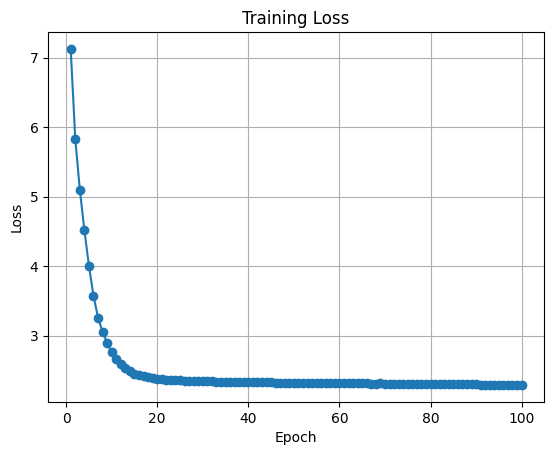

In [20]:
plot_loss(epoch_list, loss_list)

In [21]:
torch.save(model, '/content/drive/Othercomputers/내 컴퓨터/Interview_Writer/Interview_Writer_GPT_epoch{}_lr={}.pt'.format(epochs, learning_rate))

# 모델 테스트

In [26]:
load_model = torch.load('/content/drive/Othercomputers/내 컴퓨터/Interview_Writer/Interview_Writer_GPT_epoch100_lr=0.0001.pt').to(torch.device("cpu"))

In [27]:
while 1:
    document = input("질문 입력 > \n").strip()
    # quit 입력시 종료
    if document == "quit":
        break

    input_ids = fast_tokenizer.encode(document, return_tensors='pt')

    with torch.no_grad():
        output_ids = input_ids.clone()
        for _ in range(512):
            # 모델에 입력 문장을 주입하여 다음 단어 예측
            output = load_model(input_ids=output_ids).logits
            
            next_token_logits = output[0, -1, :]
            next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            
            # 생성된 토큰을 현재의 문장 끝에 추가
            output_ids = torch.cat([output_ids, next_token_id.unsqueeze(-1)], dim=-1)

    # 생성된 텍스트를 디코딩하여 원래의 형식으로 변환
    generated_text = fast_tokenizer.decode(output_ids.squeeze(), skip_special_tokens=True)
    generated_text = generated_text.replace(' ▁', '')
    # input_ids 제거
    generated_text = generated_text[len(document):]
    
    print(f'생성 결과 > \n{generated_text}')

질문 입력 > 
특별히 이 회사에 지원한 이유를 작성하시오.
생성 결과 > 
낍 시절 싫 톱칭 낚을 송 시절 콤를..을는는는 싫에 Q이을,을이.,.,.의을을,.을,한을을를을


KeyboardInterrupt: ignored